In [15]:
# importing

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn as nn
import sys
import copy
import math
from metrics import Metrics 
from sklearn.preprocessing import MinMaxScaler

In [3]:
# preparing the raw data

# Florida - HAB data 
data_file = "Florida-HAB/"
fl_df_1 = pd.read_csv(data_file+"habsos_20200310.csv")
fl_df_2 = pd.read_csv(data_file+"habsos_20190211.csv")
fl_df_3 = pd.read_csv(data_file+"habsos_20180227.csv")
fl_df_4 = pd.read_csv(data_file+"habsos_20140806.csv")
fl_df_5 = pd.read_csv(data_file+"habsos_20140806 copy.csv")

fl_dfs = [fl_df_1, fl_df_2, fl_df_3, fl_df_4, fl_df_5]

# removing excess columns
for i in range(1, len(fl_dfs)):
    fl_dfs[i].drop("qa_comment", axis=1, inplace=True)
    if i >=3:
        fl_dfs[i].drop("shape", axis=1, inplace=True)
# after the above, all fl_dfs have same columns

# adding erything together
main_fl_df = fl_dfs[0]
#print("mdf", main_fl_df.shape)
for i in range(1, len(fl_dfs)):
    temp_df = fl_dfs[i]
    #print("tdf:", temp_df.shape)
    main_fl_df, temp_df = main_fl_df.align(temp_df, join='inner', axis=1)
    main_fl_df = main_fl_df.append(temp_df, ignore_index = True) 
    #print("mdf", main_fl_df.shape)

# show duplicates in main_df
duprows = main_fl_df.duplicated()
main_fl_df[duprows]

# drop duplicates
main_fl_df.drop_duplicates(inplace=True)
main_fl_df.shape

# preprocessing the entire df
fl_df = main_fl_df

# dropping columns which only have NaN values
x = fl_df.isna().all()
y = [x[x==True].index[i] for i in range(len(x[x==True]))]
fl_df.drop(y, axis=1, inplace=True)

# dropping columns which have only 1 value or have 2 values of which 1 is nan
y = []
for col in fl_df.columns:
    unq = fl_df[col].unique()
    if (len(unq) == 2 and pd.isna(unq).any()) or len(unq) == 1:
            y.append(col)
fl_df.drop(y, axis=1, inplace=True)

# dropping other columns/rows
fl_df.drop(["objectid", "description", "state_id", "wind_dir", "wind_dir_qa", "wind_speed", "wind_speed_qa"], axis=1, inplace=True)
fl_df.drop(0, axis=0, inplace=True) # erroneous row containing date of year "0153" (probably 1953 but we can ignore 1 row)

# converting time from str to datetime
fl_df.sample_date = pd.to_datetime(fl_df.sample_date)

# category has 5 values - not observed, very low, low, medium, high.
# These are the outputs which we have to forecast
# substituting these 5 values for 0, 1, 2, 3, 4
fl_df.category.where(fl_df.category != "not observed", 0, inplace=True)
fl_df.category.where(fl_df.category != "very low", 1, inplace=True)
fl_df.category.where(fl_df.category != "low", 2, inplace=True)
fl_df.category.where(fl_df.category != "medium", 3, inplace=True)
fl_df.category.where(fl_df.category != "high", 4, inplace=True)
fl_df.category = pd.to_numeric(fl_df.category)

/home/czm/anaconda3/envs/redtide/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/czm/anaconda3/envs/redtide/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


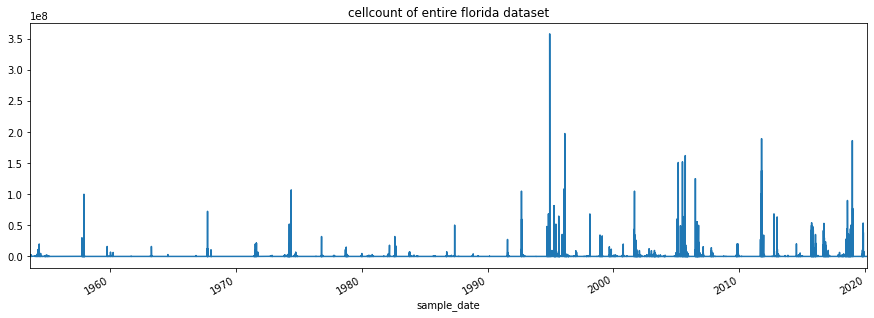

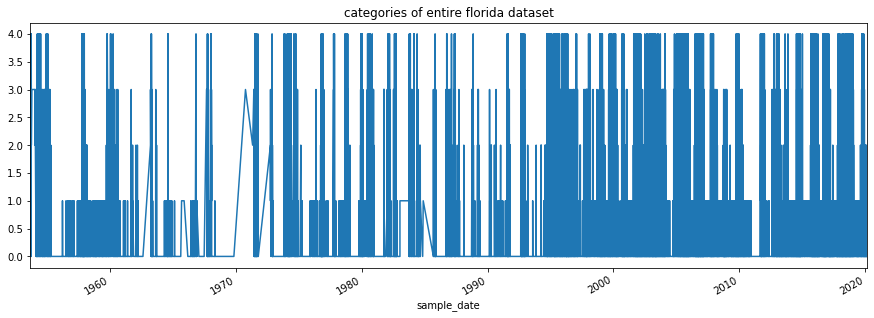

In [4]:
# converting the raw data to a time series

fl_df_ts = fl_df.set_index('sample_date')
fl_df_ts.cellcount.plot(figsize=(15,5), title="cellcount of entire florida dataset")
plt.show()
fl_df_ts.category.plot(figsize=(15,5), title="categories of entire florida dataset")
plt.show()

In [4]:
# this is to find out the largest consecutive records in a subset of locations.
def largest_conseq(bl):
    max_seq = 0
    cur_seq = 0
    
    cur_i = None
    max_i = None
    for index, row in bl.iterrows():
        if row.latitude==0:
            if cur_seq > max_seq:
                max_seq = cur_seq
                max_i = cur_i
            cur_seq=0
            cur_i = None
        else:
            if cur_i is None:
                cur_i = index
            cur_seq += 1
    return max_seq, max_i

In [5]:
# preprocessing the time series data to fixed time intervals.
# this is to find out the largest consecutive records in the deltas.
deltas = ["6H", "8H", "12H", "D", "2D", "3D", "4D", "5D", "6D", "W", "2W"]
all_data = {"delta":[], "max_seq":[], "max_freq": [], "min_miss":[], "size":[], "max_ind":[]}

i = 0
for delta in deltas:
#     print(i)
    resampled = fl_df_ts.resample(delta).sum()
    
    max_seq = 0
    max_freq = None
    max_ind = None
    min_miss = 1.0
    conseq, ind = largest_conseq(resampled)
    if ind is None:
        continue

    freq = ind.freq
    miss = len(resampled[resampled.latitude==0]) / len(resampled)

    if max_seq < conseq:
        max_seq = conseq
        max_freq = freq
        max_ind = ind
    if min_miss > miss:
        min_miss = miss

    all_data["delta"].append(delta)
    all_data["max_seq"].append(max_seq)
    all_data["max_ind"].append(max_ind)
    all_data["max_freq"].append(max_freq)
    all_data["min_miss"].append(min_miss)
    all_data["size"].append(len(resampled))
    i+=1
#     print("max conseq:", max_seq)
#     print("max index:", max_ind)
#     print("for freq:", max_freq)
#     print("min miss(%):", min_miss)
#     print("######################################")

0
1
2
3
4
5
6
7
8
9
10


In [6]:
# taking the different frequencies data and puttting it in a dataframe for visualizing 

df = pd.DataFrame(all_data)
effective_seq = [3,4,6,12,24,36,48,60,72,84,168]
df["effective_seq"] = df.max_seq.multiply(effective_seq, axis=0)
df

,delta,max_seq,max_freq,min_miss,size,max_ind,effective_seq
0,6H,67,<6 * Hours>,0.790578,97239,2018-10-08 12:00:00,201
1,8H,68,<8 * Hours>,0.743929,72929,2017-06-06 08:00:00,272
2,12H,83,<12 * Hours>,0.694056,48620,2018-09-14 12:00:00,498
3,D,215,<Day>,0.593089,24310,2019-01-21 00:00:00,2580
4,2D,454,<2 * Days>,0.489757,12155,2017-09-10 00:00:00,10896
5,3D,876,<3 * Days>,0.417201,8104,2012-12-25 00:00:00,31536
6,4D,574,<4 * Days>,0.367062,6078,2004-09-20 00:00:00,27552
7,5D,459,<5 * Days>,0.330317,4862,2004-09-20 00:00:00,27540
8,6D,573,<6 * Days>,0.301333,4052,2001-08-07 00:00:00,41256
9,W,706,<Week: weekday=6>,0.275187,3474,1997-06-29 00:00:00,59304


1043


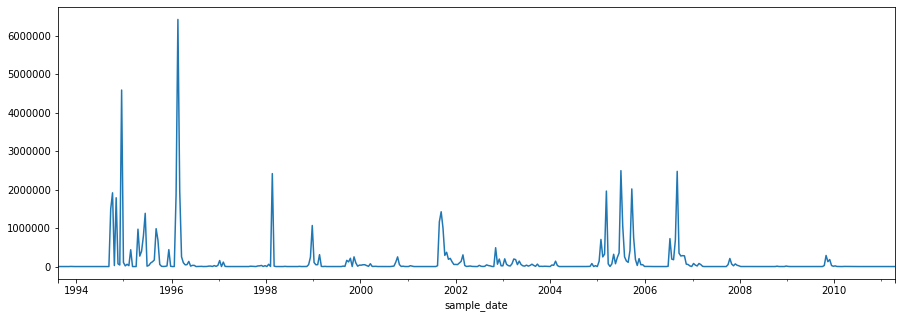

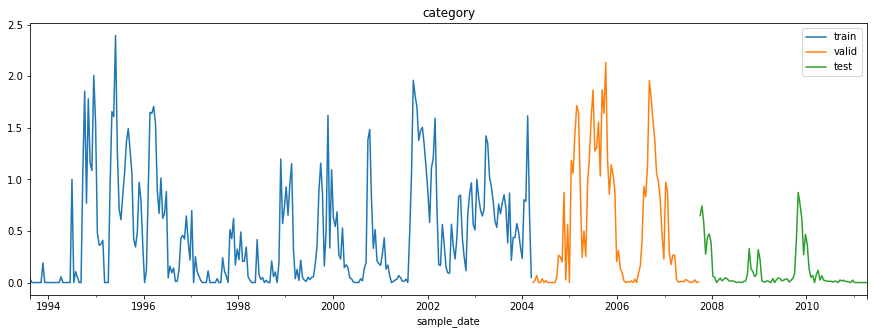

In [306]:
# taking effective_seq and breaking it into train, valid and test sets

# 10	2W	462	<2 * Weeks: weekday=6>	0.191024	1738	1993-08-15 00:00:00	77616
# starting loc: 7226
max_seq_ts = fl_df_ts.resample("2W").mean()

st_loc = max_seq_ts.index.get_loc("1993-08-15 00:00:00")
print(st_loc)

max_seq_ts.iloc[st_loc:st_loc+462].cellcount.plot(figsize=(15,5))
plt.show()

working_data = max_seq_ts.iloc[st_loc:st_loc+462].category


# train:valid:test = 0.6:0.2:0.2

fig= plt.figure(figsize=(15,5))
ax = working_data.iloc[:int(len(working_data)*0.6)].plot()
ax = working_data.iloc[int(len(working_data)*0.6): int(len(working_data)*0.8)].plot()
ax = working_data.iloc[int(len(working_data)*0.8):].plot()
ax.legend(["train", "valid", "test"])
plt.title("category")
plt.show()


working_data = working_data.values

n = len(working_data)
train_data, test_data = working_data[:int(n*0.8)], working_data[int(n*0.8):]
n = len(train_data)
train_data, valid_data = train_data[:int(n*0.75)], train_data[int(n*0.75):]


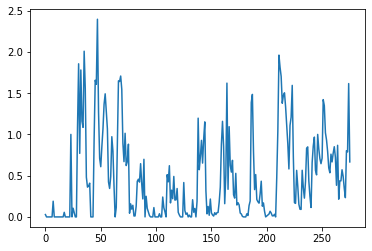

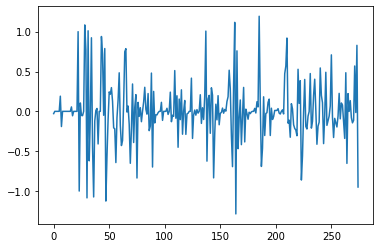

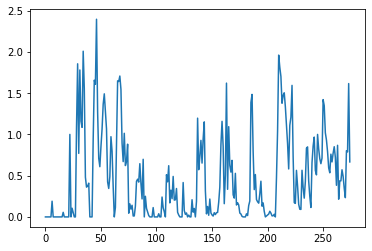

In [141]:
# transforming the data to stationary (its dependent on time)
# we do this because stationary data is easier to model and will result in better forecasts
# we can make the data stationary by calculating the differences

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


train_stat = difference(train_data, 1)
valid_stat = difference(valid_data, 1)
test_stat = difference(test_data, 1)

# showing the train original vs stationary
plt.plot(train_data)
plt.show()
plt.plot(train_stat)
plt.show()

# invert transform
inverted = list()
for i in range(len(train_stat)):
    value = inverse_difference(train_data, train_stat[i], len(train_data)-i)
    inverted.append(value)
plt.plot(inverted)


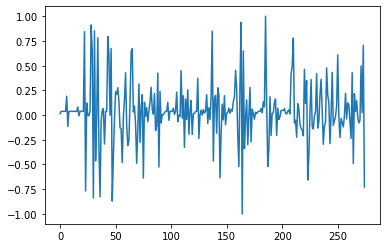

In [307]:
# normalizing the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_stat.reshape(-1, 1))
valid_norm = scaler.transform(valid_stat.reshape(-1,1))
test_norm = scaler.transform(test_stat.reshape(-1,1))

# visualizing train_norm
plt.plot(train_norm)
plt.show()

In [37]:
# make everything tensors

train_norm = torch.FloatTensor(train_norm).view(-1)
valid_norm = torch.FloatTensor(valid_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [38]:
# to create the training/valid/test window data sequences

window_size = 4 # 2 months at a time

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


train_seq = create_inout_sequences(train_norm, window_size)
valid_seq = create_inout_sequences(valid_norm, window_size)
test_seq = create_inout_sequences(test_norm, window_size)

train_seq


[(tensor([0.0147, 0.0377, 0.0377, 0.0377]), tensor([0.0377])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0377]), tensor([0.0377])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0377]), tensor([0.1913])),
 (tensor([0.0377, 0.0377, 0.0377, 0.1913]), tensor([-0.1159])),
 (tensor([ 0.0377,  0.0377,  0.1913, -0.1159]), tensor([0.0377])),
 (tensor([ 0.0377,  0.1913, -0.1159,  0.0377]), tensor([0.0377])),
 (tensor([ 0.1913, -0.1159,  0.0377,  0.0377]), tensor([0.0377])),
 (tensor([-0.1159,  0.0377,  0.0377,  0.0377]), tensor([0.0377])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0377]), tensor([0.0377])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0377]), tensor([0.0377])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0377]), tensor([0.0377])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0377]), tensor([0.0377])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0377]), tensor([0.0825])),
 (tensor([0.0377, 0.0377, 0.0377, 0.0825]), tensor([-0.0071])),
 (tensor([ 0.0377,  0.0377,  0.0825, -0.0071]), tensor([0.0377])),
 (tensor([ 0.0377,  0.0825, -0.00

In [20]:
# test entire sequence

def test(model, sequence, og_vals, scaler, window_size=4):
    all_preds = np.array([])
    all_targets = np.array([])
    model.to(device)
    
    test_seq = sequence[0][0]
    with torch.no_grad():
        for i in range(len(sequence)):
            input_seq = test_seq[-window_size:]
            if "LSTM" in str(model):
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
            
            outputs = model(input_seq)
#             outputs = sequence[i][1] # yhat = y for checking
#             outputs = -1*outputs # yhat = -y. should lead to a large RMSE
            
            # invert scaling
            pred = scaler.inverse_transform(np.array([[outputs.item()]]))
            # invert differencing  
            pred = og_vals[window_size+i] + pred 
            pred = pred[0][0]
            
            trgt = og_vals[window_size+1+i]
            
#             print("model output:", outputs)
#             print("pred:", pred)
#             print("target:", trgt)
#             print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            
            all_preds = np.append(all_preds, pred)
            all_targets = np.append(all_targets, trgt)
            
            test_seq = torch.cat((test_seq, outputs), 0)
            
    return all_preds, all_targets
                

In [21]:
def train(model, trainSeq, validSeq, trainOg, validOg, scaler, save = True, earlyStopping=None, epochs=100, verbose=True):
    all_train_loss = []
    all_valid_loss = []

    model = model.float()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    best_loss = sys.float_info.max
    loss = None
    valid_loss = None
    train_loss = None
    other_stats = {"loss": [], 'mae-train':[], 'mae-valid':[]}
    
    best_model_weights = copy.deepcopy(model.state_dict())
    epoch = 0
    while epoch < epochs:
        running_loss = 0.0
         
        for i, data in enumerate(trainSeq):
            #get the unputs; data is a list of [inputs, labels]
            inputs, target = data
            inputs = inputs.to(device).float()

            #zero the param gradients
            optimizer.zero_grad()
            
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            
            #forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, target)

            loss.sum().backward()
            optimizer.step()

            running_loss += loss.sum().item()

            #print("batch no.:",i)
            # batch statistics
            if (i) % 4 == 0:
                #every 4 batch print - loss, training acc, validation acc
                train_pred, train_target = test(model, trainSeq, trainOg, scaler)
                valid_pred, valid_target = test(model, validSeq, validOg, scaler)
                train_loss = math.sqrt(mean_squared_error(train_target, train_pred))
                valid_loss = math.sqrt(mean_squared_error(valid_target, valid_pred))
                train_mae = mean_absolute_error(train_target, train_pred)
                valid_mae = mean_absolute_error(valid_target, valid_pred)
                
                
                if verbose:
                    print('Running Training Loss:', running_loss)
                    print('Training RMSE:', train_loss)
                    print('Valid RMSE:', valid_loss)
                    print('Training MAE:', train_mae)
                    print('Valid MAE:', valid_mae)
                    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_model_weights = copy.deepcopy(model.state_dict())

                
                other_stats['loss'].append(running_loss)
                running_loss = 0.0

                all_train_loss.append(train_loss)
                all_valid_loss.append(valid_loss)
                other_stats['mae-train'].append(train_mae)
                other_stats['mae-valid'].append(valid_mae)
            
        epoch += 1

        model.load_state_dict(best_model_weights)

#         #early stopping checked every epoch rather than every minibatch
#         if earlyStopping is not None and earlyStopping.step(valid_loss):
#             break

    if save == True:
        path_to_statedict = './models/'+str(model)+"-1.0.pth"
        torch.save(model.state_dict(), path_to_statedict)

    print('Finished Training')

    return all_train_loss, all_valid_loss, epoch, other_stats


In [22]:
# The model

import torch
import torch.nn as nn

class LSTM(nn.Module):
    version = 1.0
    def __init__(self, input_size=1, hidden_layer_size=1, output_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        
        i = input_seq.view(len(input_seq) ,1, -1)
        lstm_out, self.hidden_cell = self.lstm(i, self.hidden_cell)
#         print("~~~~~~~~~~~~~~~~~")
#         print(i.shape)
#         print("lstmOut:",lstm_out)
#         print("hc:",self.hidden_cell)
#         print("##################")
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
    def __str__(self):
        return type(self).__name__ + "_" + str(self.version)

class BaseLine(nn.Module):
    version = 1.0
    def forward(self, input_seq):
        i = input_seq.view(len(input_seq), -1)
        return i[-1]
    def __str__(self):
        return type(self).__name__ + "_" + str(self.version)  

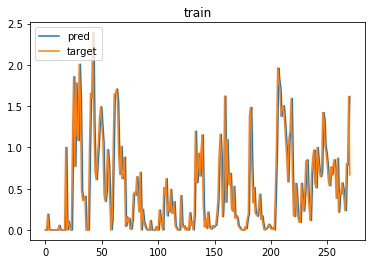

train-RMSE: 0.3730571250704675
train-MAE: 0.24139029613638058


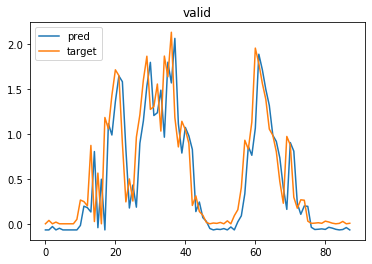

valid-RMSE: 0.3644715301120665
valid-MAE: 0.2477043143790179


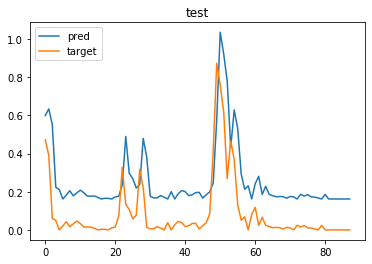

test-RMSE: 0.19712642053243176
test-MAE: 0.2477043143790179


In [397]:
# baseline model
model = BaseLine()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# testing the train dataset
train_preds, train_targets = test(model, train_seq, train_data)
m.plot_series({"pred": train_preds, "target":train_targets},  title='train')
print("train-RMSE:",math.sqrt(mean_squared_error(train_targets, train_preds)))
print("train-MAE:",mean_absolute_error(train_targets, train_preds))

# testing the valid dataset
valid_preds, valid_targets = test(model, valid_seq, valid_data)
m.plot_series({"pred": valid_preds, "target":valid_targets},  title='valid')
print("valid-RMSE:",math.sqrt(mean_squared_error(valid_targets, valid_preds)))
print("valid-MAE:",mean_absolute_error(valid_targets, valid_preds))

# testing the test dataset
test_preds, test_targets = test(model, test_seq, test_data)
m.plot_series({"pred": test_preds, "target":test_targets},  title='test')
print("test-RMSE:", math.sqrt(mean_squared_error(test_targets, test_preds)))
print("test-MAE:",mean_absolute_error(valid_targets, valid_preds))

so we can see the LSTM model with window = 4, hidden dimension = 1 is better than the baseline. 

lets try a different approach. lets take all the data and imput missing values

so this is the general technique:
1. mark missing values
2. impute them
    1. set smaller weightage (0.5) to them 
3. fit model on them
4. compare model losses, to see which imputation technique is better. 

the resampled dataset we'll work with is the 2W one as that has the least min_miss


In [399]:
# as we can see the lowest missing data is in the 2 weeks. we can impute the data.
df

,delta,max_seq,max_freq,min_miss,size,max_ind,effective_seq
0,6H,67,<6 * Hours>,0.790578,97239,2018-10-08 12:00:00,201
1,8H,68,<8 * Hours>,0.743929,72929,2017-06-06 08:00:00,272
2,12H,83,<12 * Hours>,0.694056,48620,2018-09-14 12:00:00,498
3,D,215,<Day>,0.593089,24310,2019-01-21 00:00:00,2580
4,2D,454,<2 * Days>,0.489757,12155,2017-09-10 00:00:00,10896
5,3D,876,<3 * Days>,0.417201,8104,2012-12-25 00:00:00,31536
6,4D,574,<4 * Days>,0.367062,6078,2004-09-20 00:00:00,27552
7,5D,459,<5 * Days>,0.330317,4862,2004-09-20 00:00:00,27540
8,6D,573,<6 * Days>,0.301333,4052,2001-08-07 00:00:00,41256
9,W,706,<Week: weekday=6>,0.275187,3474,1997-06-29 00:00:00,59304


In [8]:
# 1. mark missing values using -1
resampled = fl_df_ts.resample("2W").mean()

resampled.category = resampled.category.astype(float) # to assign np.nan and impute

for index, row in resampled.iterrows():
    if np.isnan(row.latitude):
        resampled.set_value(index, 'category', np.nan)

imputed_indices = resampled[resampled.category.isnull()].index

/home/czm/anaconda3/envs/redtide/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [23]:
def evaluate(model, technique, seqs, data, df_data,scaler, verbose=False):
    df_data["model"].append(str(model)+"-"+str(technique))

    sets = ["train", "valid", "test"]
    mses = []
    maes = []
    for i in range(3):
        title = sets[i]

        print("evaluating the", title, "set")
        preds, targets = test(model, seqs[i], data[i], scaler)

        rmse = math.sqrt(mean_squared_error(targets, preds))
        mae = mean_absolute_error(targets, preds)

        df_data[title+"_rmse"].append(rmse)
        df_data[title+"_mae"].append(mae)
        
        if verbose:
            m.plot_series({"pred": preds, "target":targets},  title=title)
            print(title+"-RMSE:", rmse)
            print(title+"-MAE:", mae)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]



In [26]:
def preprocess_fit(imputed_sample, method, df_data, verbose=False):
    # 3. fit model on them:
    working_data = imputed_sample

    # train:valid:test = 0.6:0.2:0.2
    if verbose:
        fig= plt.figure(figsize=(15,5))
        ax = working_data.iloc[:int(len(working_data)*0.6)].plot()
        ax = working_data.iloc[int(len(working_data)*0.6): int(len(working_data)*0.8)].plot()
        ax = working_data.iloc[int(len(working_data)*0.8):].plot()
        ax.legend(["train", "valid", "test"])
        plt.title("category")
        plt.show()


    working_data = working_data.values

    n = len(working_data)
    train_data, test_data = working_data[:int(n*0.8)], working_data[int(n*0.8):]
    n = len(train_data)
    train_data, valid_data = train_data[:int(n*0.75)], train_data[int(n*0.75):]

    # differencing 
    train_stat = difference(train_data, 1)
    valid_stat = difference(valid_data, 1)
    test_stat = difference(test_data, 1)

    if verbose:
        # showing the train original vs stationary
        plt.plot(train_data)
        plt.show()
        plt.plot(train_stat)
        plt.show()

        # invert transform
        inverted = list()
        for i in range(len(train_stat)):
            value = inverse_difference(train_data, train_stat[i], len(train_data)-i)
            inverted.append(value)
        plt.plot(inverted)
        plt.show()


    # normalizing the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_norm = scaler.fit_transform(train_stat.reshape(-1, 1))
    valid_norm = scaler.transform(valid_stat.reshape(-1,1))
    test_norm = scaler.transform(test_stat.reshape(-1,1))

    if verbose:
        # visualizing train_norm
        plt.plot(train_norm)
        plt.show()


    # make everything tensors

    train_norm = torch.FloatTensor(train_norm).view(-1)
    valid_norm = torch.FloatTensor(valid_norm).view(-1)
    test_norm = torch.FloatTensor(test_norm).view(-1)


    # to create the training/valid/test window data sequences

    window_size = 4 # 2 months at a time

    train_seq = create_inout_sequences(train_norm, window_size)
    valid_seq = create_inout_sequences(valid_norm, window_size)
    test_seq = create_inout_sequences(test_norm, window_size)
    
    seqs = [train_seq, valid_seq, test_seq]
    raw_data = [train_data, valid_data, test_data]
    
    # baseline model
    model = BaseLine()
    evaluate(model, method, seqs, raw_data, df_data, scaler, verbose)
    
    torch.manual_seed(3)
    torch.cuda.manual_seed(3)
    
    # lstm model
    model = LSTM()
    train_loss, valid_loss, epoch, o_stats =  train(model, train_seq, valid_seq, train_data, valid_data, scaler, 
                                                    epochs=2, verbose=verbose)

    # train and valid RMSE, MAE
    Metrics.plot_series({"train":train_loss, "valid":valid_loss}, title="RMSE loss of method:"+method+" over training")
    Metrics.plot_series({"train":o_stats['mae-train'], "valid":o_stats['mae-valid']}, title="MAE loss of method:"+method+" over training")

    evaluate(model, method, seqs, raw_data, df_data, scaler, verbose)
    
    torch.cuda.empty_cache()


evaluating the train set
evaluating the valid set
evaluating the test set
Finished Training


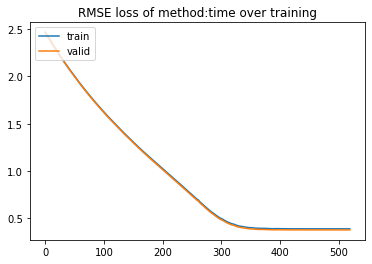

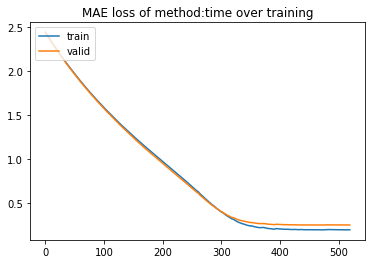

evaluating the train set
evaluating the valid set
evaluating the test set
evaluating the train set
evaluating the valid set
evaluating the test set
Finished Training


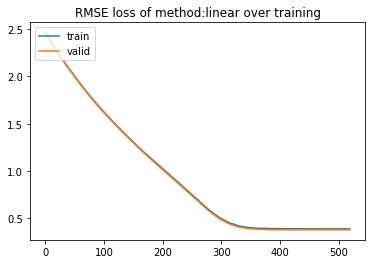

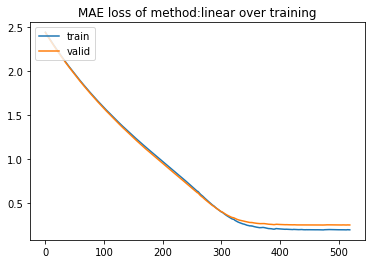

evaluating the train set
evaluating the valid set
evaluating the test set
evaluating the train set
evaluating the valid set
evaluating the test set
Finished Training


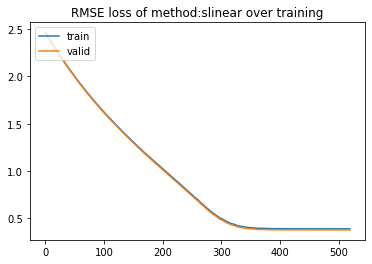

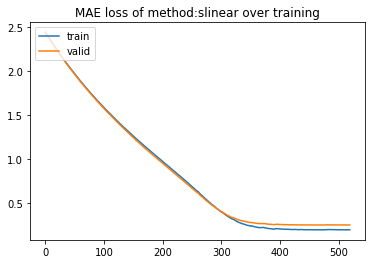

evaluating the train set
evaluating the valid set
evaluating the test set
evaluating the train set
evaluating the valid set
evaluating the test set
Finished Training


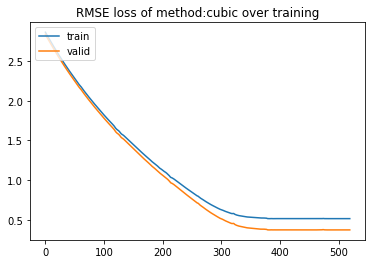

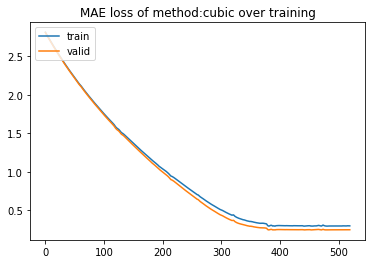

evaluating the train set
evaluating the valid set
evaluating the test set
evaluating the train set
evaluating the valid set
evaluating the test set
Finished Training


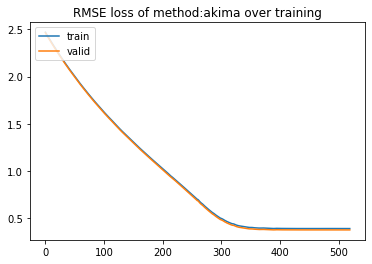

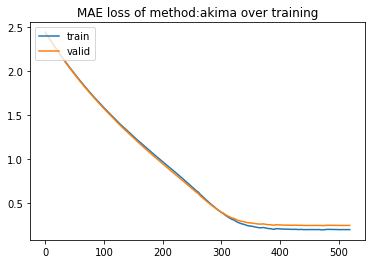

evaluating the train set
evaluating the valid set
evaluating the test set


In [27]:
df_data = {"model":[], "train_rmse":[], "valid_rmse":[], "test_rmse":[], "train_mae":[], "valid_mae":[], "test_mae":[]}

imputed_samples = []
methods = ["time", "linear", "slinear", "cubic", "akima"]
device = torch.device("cpu")
for m in methods:
    imputed_sample = resampled.category.interpolate(method=m)
    preprocess_fit(imputed_sample, m, df_data)
    

In [28]:
DF = pd.DataFrame(df_data)
DF

,model,train_rmse,valid_rmse,test_rmse,train_mae,valid_mae,test_mae
0,BaseLine_1.0-time,1.074602,0.374872,0.270464,1.022614,0.244775,0.174299
1,LSTM_1.0-time,0.386315,0.374882,0.254401,0.190414,0.245996,0.134670
2,BaseLine_1.0-time,1.074602,0.374872,0.270464,1.022614,0.244775,0.174299
3,LSTM_1.0-time,0.386315,0.374882,0.254401,0.190414,0.245996,0.134670
4,BaseLine_1.0-time,1.074602,0.374872,0.270464,1.022614,0.244775,0.174299
5,LSTM_1.0-time,0.386315,0.374882,0.254401,0.190414,0.245996,0.134670
6,BaseLine_1.0-time,1.128050,0.374872,0.270658,1.040903,0.244775,0.174299
7,LSTM_1.0-time,0.516571,0.374861,0.254508,0.294777,0.245315,0.133713
8,BaseLine_1.0-time,1.075588,0.374872,0.270476,1.022614,0.244775,0.174299
9,LSTM_1.0-time,0.388947,0.374867,0.254279,0.195971,0.244903,0.133246
